In [1]:
!pip install -q python-igraph scikit-learn ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 535kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.41MB/s]


Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_k_nearest_neighbors_graph(unique_vectors, k):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node.
    Each node is connected to its k nearest neighbors (excluding itself).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d) containing feature vectors.
        k (int): Number of nearest neighbors for each node.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted k-NN graph for {n} nodes...")

    # Find k nearest neighbors for each node. Note: The first neighbor is the point itself.
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, neigh in enumerate(indices):
        # Skip the first neighbor (self) and add undirected edges only once.
        for j in neigh[1:]:
            if i < j:
                edge_list.append((i, j))

    # Create an undirected graph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Unweighted k-NN graph built with {len(edge_list)} edges.")
    return g

g = visualize_k_nearest_neighbors_graph(unique_vectors, 5)


Building unweighted k-NN graph for 6726 nodes...
Unweighted k-NN graph built with 15285 edges.


In [4]:
def build_filtered_knn_graph(unique_vectors, k, max_distance=6.0):
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building filtered k-NN graph for {n} nodes with edge dist ≤ {max_distance}...")

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, (neighbors, dists) in enumerate(zip(indices, distances)):
        for j, dist in zip(neighbors[1:], dists[1:]):  # skip self (index 0)
            if dist <= max_distance and i < j:
                edge_list.append((i, j))

    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Filtered k-NN graph built with {len(edge_list)} edges.")
    return g

threshold = 6
g_thresh = build_filtered_knn_graph(unique_vectors, k=5, max_distance=threshold)


Building filtered k-NN graph for 6726 nodes with edge dist ≤ 6...
Filtered k-NN graph built with 15068 edges.


In [5]:
components = g_thresh.clusters()
largest_component_index = components.sizes().index(max(components.sizes()))
g_largest = g_thresh.subgraph(components[largest_component_index])
mapping = components[largest_component_index]  # Maps subgraph idx → original idx
print(f"Largest component: {g_largest.vcount()} nodes, {g_largest.ecount()} edges.")


Largest component: 6372 nodes, 15015 edges.


<ipython-input-5-1dcb5f0051b5>:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = g_thresh.clusters()


In [6]:
dist_matrix = g_largest.shortest_paths()
dist_matrix = np.array(dist_matrix)
max_dist = np.max(dist_matrix)
i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
print(f"Furthest nodes: {i} and {j} with shortest path length {max_dist}")


<ipython-input-6-9fed582e627f>:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = g_largest.shortest_paths()


Furthest nodes: 0 and 6339 with shortest path length 38


In [7]:
# Get the shortest path (as list of node indices)
path = g_largest.get_shortest_paths(i, to=j, output='vpath')[0]

# Reuse original vectors for distance calculation
vectors_np = unique_vectors.numpy()
path_distances = []

for idx in range(len(path) - 1):
    u, v = path[idx], path[idx + 1]
    vec_u = vectors_np[mapping[u]]
    vec_v = vectors_np[mapping[v]]
    dist = np.linalg.norm(vec_u - vec_v)
    path_distances.append(dist)
    print(f"Edge {u} -> {v} | L2 distance: {dist:.4f}")

total_path_distance = sum(path_distances)
print(f"\nTotal L2 distance along path: {total_path_distance:.4f}")


Edge 0 -> 1 | L2 distance: 5.9161
Edge 1 -> 116 | L2 distance: 4.8990
Edge 116 -> 108 | L2 distance: 4.5826
Edge 108 -> 2304 | L2 distance: 4.7958
Edge 2304 -> 2384 | L2 distance: 4.2426
Edge 2384 -> 125 | L2 distance: 4.3589
Edge 125 -> 26 | L2 distance: 5.3852
Edge 26 -> 364 | L2 distance: 5.2915
Edge 364 -> 2664 | L2 distance: 4.8990
Edge 2664 -> 2806 | L2 distance: 5.0000
Edge 2806 -> 557 | L2 distance: 4.6904
Edge 557 -> 849 | L2 distance: 4.5826
Edge 849 -> 842 | L2 distance: 4.3589
Edge 842 -> 1199 | L2 distance: 4.3589
Edge 1199 -> 1182 | L2 distance: 3.7417
Edge 1182 -> 1109 | L2 distance: 3.6056
Edge 1109 -> 1103 | L2 distance: 3.7417
Edge 1103 -> 1549 | L2 distance: 3.7417
Edge 1549 -> 1472 | L2 distance: 4.3589
Edge 1472 -> 1833 | L2 distance: 4.1231
Edge 1833 -> 2208 | L2 distance: 3.7417
Edge 2208 -> 2197 | L2 distance: 3.7417
Edge 2197 -> 5690 | L2 distance: 3.8730
Edge 5690 -> 6186 | L2 distance: 2.4495
Edge 6186 -> 5691 | L2 distance: 3.6056
Edge 5691 -> 6142 | L2 dist

In [8]:
for idx in range(len(path) - 1):
    u, v = path[idx], path[idx + 1]
    vec_u = vectors_np[u]
    vec_v = vectors_np[v]
    direction = vec_v - vec_u

    print(f"\nEdge {u} -> {v}:")
    print("l(t) = u + t * (v - u), where t ∈ [0, 1]")
    print(f"u (start): {vec_u[:5]} ...")  # print only first 5 dims
    print(f"v (end):   {vec_v[:5]} ...")
    print(f"v - u:     {direction[:5]} ...")



Edge 0 -> 1:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 1 -> 116:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 116 -> 108:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 108 -> 2304:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 2304 -> 2384:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 2384 -> 125:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 125 -> 26:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0.

In [12]:
import numpy as np

# Step 1: Get the actual vectors for start and end
vec_start = vectors_np[mapping[path[0]]]
vec_end   = vectors_np[mapping[path[-1]]]

# Step 2: Compute linear interpolated points at t = 0.05, 0.10, ..., 0.95
ts = np.linspace(0.05, 0.95, 19)
linear_interp_vectors = [(1 - t) * vec_start + t * vec_end for t in ts]

# Step 3: Compute cumulative distances along the real graph path
graph_vectors = [vectors_np[mapping[node]] for node in path]
cum_dists = [0.0]
for i in range(1, len(graph_vectors)):
    dist = np.linalg.norm(graph_vectors[i] - graph_vectors[i-1])
    cum_dists.append(cum_dists[-1] + dist)

total_graph_distance = cum_dists[-1]
total_linear_distance = np.linalg.norm(vec_end - vec_start)
print(f"Total real graph distance: {total_graph_distance:.4f}")
print(f"Total linear distance:     {total_linear_distance:.4f}")

# Step 4: Get graph vectors at approximately matching 5% points
graph_interp_vectors = []
for target_frac in ts:
    target_dist = target_frac * total_graph_distance
    # Find the first segment that passes the target distance
    for i in range(1, len(cum_dists)):
        if cum_dists[i] >= target_dist:
            graph_interp_vectors.append(graph_vectors[i])
            break

# Step 5: Compare each pair of vectors
direction = vec_end - vec_start
direction = direction / np.linalg.norm(direction)

print("t\tL2 deviation\tcos(angle to direction)")
for t, lin_vec, graph_vec in zip(ts, linear_interp_vectors, graph_interp_vectors):
    delta = graph_vec - lin_vec
    l2 = np.linalg.norm(delta)
    cos_angle = np.dot(delta, direction) / (np.linalg.norm(delta) + 1e-9)
    print(f"{t:.2f}\t{l2:.4f}\t\t{cos_angle:.4f}")



Total real graph distance: 158.5491
Total linear distance:     10.7238
t	L2 deviation	cos(angle to direction)
0.05	6.6248		0.1161
0.10	7.9215		0.0647
0.15	8.2394		0.0198
0.20	8.5790		0.0217
0.25	9.3374		-0.0275
0.30	9.4419		-0.0247
0.35	9.4439		-0.0321
0.40	9.4763		0.0098
0.45	9.1317		-0.0077
0.50	9.3140		-0.0551
0.55	9.0104		-0.0750
0.60	8.8204		-0.1163
0.65	8.9212		-0.1542
0.70	8.3756		-0.1392
0.75	7.9804		-0.2132
0.80	7.4699		-0.1748
0.85	6.9848		-0.2503
0.90	6.4459		-0.3110
0.95	4.4707		-0.1512


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


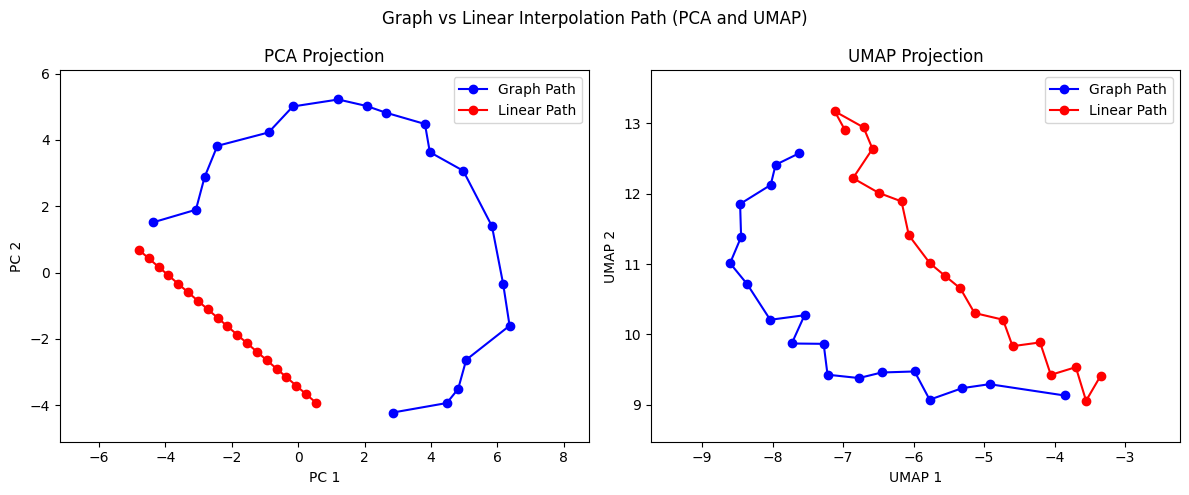

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

# Assume you already have:
# - graph_interp_vectors (list of graph path vectors)
# - linear_interp_vectors (list of linearly interpolated vectors)

# Stack them together for joint projection
all_vectors = np.stack(graph_interp_vectors + linear_interp_vectors)  # shape (2N, 784)

# ---------- PCA ----------
pca = PCA(n_components=2)
all_pca = pca.fit_transform(all_vectors)
graph_pca = all_pca[:len(graph_interp_vectors)]
linear_pca = all_pca[len(graph_interp_vectors):]

# ---------- UMAP ----------
reducer = umap.UMAP(n_components=2, random_state=42)
all_umap = reducer.fit_transform(all_vectors)
graph_umap = all_umap[:len(graph_interp_vectors)]
linear_umap = all_umap[len(graph_interp_vectors):]

# ---------- Plotting ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ----- PCA Plot -----
axs[0].plot(graph_pca[:, 0], graph_pca[:, 1], '-o', label='Graph Path', color='blue')
axs[0].plot(linear_pca[:, 0], linear_pca[:, 1], '-o', label='Linear Path', color='red')
axs[0].set_title("PCA Projection")
axs[0].set_xlabel("PC 1")
axs[0].set_ylabel("PC 2")
axs[0].axis('equal')
axs[0].legend()

# ----- UMAP Plot -----
axs[1].plot(graph_umap[:, 0], graph_umap[:, 1], '-o', label='Graph Path', color='blue')
axs[1].plot(linear_umap[:, 0], linear_umap[:, 1], '-o', label='Linear Path', color='red')
axs[1].set_title("UMAP Projection")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].axis('equal')
axs[1].legend()

plt.suptitle("Graph vs Linear Interpolation Path (PCA and UMAP)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


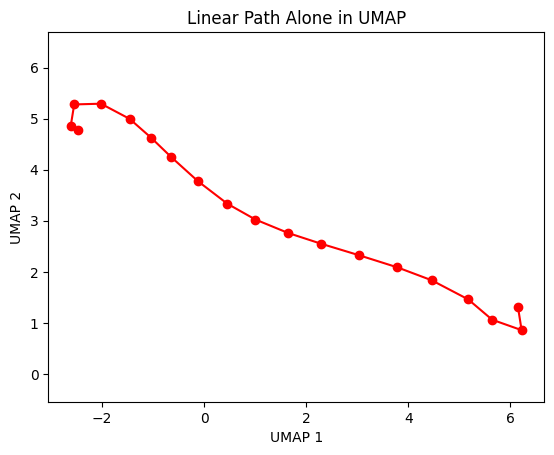

In [18]:
linear_np = np.stack(linear_interp_vectors)
reducer = umap.UMAP(n_neighbors=5, random_state=42)
linear_umap_alone = reducer.fit_transform(linear_np)

plt.plot(linear_umap_alone[:, 0], linear_umap_alone[:, 1], '-o', color='red')
plt.title("Linear Path Alone in UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.axis('equal')
plt.show()


In [13]:
import numpy as np

direction = vec_end - vec_start
unit_direction = direction / np.linalg.norm(direction)

print(f"{'t':<6}{'Along (scalar)':<20}{'Deviation (L2)':<20}")
print("-" * 50)

for t, graph_vec in zip(ts, graph_interp_vectors):
    # Step 1: vector from start to this graph point
    vector_to_point = graph_vec - vec_start

    # Step 2: how far along the line is this point?
    parallel_scalar = np.dot(vector_to_point, unit_direction)

    # Step 3: reconstruct the "shadow" on the line - where does the graph node fall on the line
    projection_point = vec_start + parallel_scalar * unit_direction

    # Step 4: measure the sideways offset (how far off the line)
    deviation_vector = graph_vec - projection_point
    deviation_distance = np.linalg.norm(deviation_vector)

    print(f"{t:<6.2f}{parallel_scalar:<20.4f}{deviation_distance:<20.4f}")


t     Along (scalar)      Deviation (L2)      
--------------------------------------------------
0.05  1.3055              6.5799              
0.10  1.5853              7.9049              
0.15  1.7718              8.2378              
0.20  2.3313              8.5770              
0.25  2.4245              9.3339              
0.30  2.9840              9.4390              
0.35  3.4503              9.4390              
0.40  4.3828              9.4758              
0.45  4.7558              9.1314              
0.50  4.8490              9.2998              
0.55  5.2220              8.9850              
0.60  5.4085              8.7606              
0.65  5.5950              8.8145              
0.70  6.3410              8.2941              
0.75  6.3410              7.7969              
0.80  7.2735              7.3550              
0.85  7.3668              6.7624              
0.90  7.6465              6.1262              
0.95  9.5115              4.4193              


In [14]:
import numpy as np

# Step 1: Compute normalized direction vectors between points
directions = []
for i in range(len(graph_interp_vectors) - 1):
    diff = graph_interp_vectors[i+1] - graph_interp_vectors[i]
    norm = np.linalg.norm(diff)
    directions.append(diff / norm if norm > 0 else diff)

# Step 2: Compute angle between consecutive directions
angles = []
for i in range(len(directions) - 1):
    dot = np.dot(directions[i], directions[i+1])
    dot = np.clip(dot, -1.0, 1.0)  # to avoid numerical issues
    angle = np.arccos(dot)  # in radians
    angles.append(np.degrees(angle))  # convert to degrees for readability

# Step 3: Print the results
print(f"{'Segment':<10}{'Turning angle (deg)':<20}")
print("-" * 30)
for i, angle in enumerate(angles):
    print(f"{i:<10}{angle:<20.2f}")


Segment   Turning angle (deg) 
------------------------------
0         104.48              
1         109.11              
2         116.05              
3         102.79              
4         96.40               
5         96.04               
6         98.36               
7         114.22              
8         90.00               
9         104.53              
10        99.86               
11        95.90               
12        93.61               
13        93.13               
14        97.68               
15        99.86               
16        107.11              
